### 멘토님 피드백

* holiday별로 rating의 유의미한 차이가 있는지 (막대그래프 등등)
* 나머지 수치형 변수 - rating의 관계가 있는지 (상관계수)
* `년도, 월, 계절(3-5월 : 봄, 6-8월 : 여름, 9-11월 : 가을, 12-2월:겨울)` 변수를 범주형 변수로 추가해서 rating과 유의미한 관계 파악해보고 추가 변수로 고려하는 것이 의미가 있을지
* target 값인 시청률을 피처에도 넣어 고려를 해보는 게 좋을지 ..? (=> 주가 예측 ??)
* 모델링 시 layer에 관한 조언
* 고전적인 시계열 모델인 arima 모델이 단기 시계열 예측에 활용이 많이 된다고 하였는데 서치를 해보니 피처를 고려하는 실습을 찾을수 ..

# 1. 탐색적 데이터 분석(EDA)

## 1-1. 데이터 둘러보기

In [1]:
# 필요 모듈 설치
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM,Dropout
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

In [2]:
# 코드깨짐 방지 (폰트를 해당 파일 위치와 같은 곳에 깔아두고, 아래 코드 실행)
from matplotlib import font_manager, rc

if os.name=='posix':
    plt.rc('font', family = 'AppleGothic')
elif os.name=='nt':
    plt.rc('font', family = 'Malgun Gothic')
plt.rc('axes',unicode_minus=False)

%config InlineBackend.figure_format='retina'

In [3]:
# 데이터 불러오기
df = pd.read_csv('./racoi_rating.csv')

### 데이터 양 파악

In [4]:
df.shape

(256, 17)

### 피처 이해

In [5]:
df.head(3)

,date,rating,episode,holiday,holiday(inform),before,after,시청자버즈(게시글),시청자버즈(댓글),시청자버즈(동영상조회),미디어버즈(뉴스),미디어버즈(동영상),기온,강수량,풍속,습도,적설
0,2017.5.7,6.3,349,0,NaN,1.2,5.6,254,1677,531883,134,10,21.4,0.0,4.2,25.1,0.0
1,2017.5.14,6.6,350,0,NaN,1.3,8.1,314,1957,346255,114,10,19.2,0.0,4.3,36.6,0.0
2,2017.5.21,5.9,351,0,NaN,1.0,6.2,323,1781,296029,225,10,24.6,0.0,2.8,41.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             256 non-null    object 
 1   rating           256 non-null    float64
 2   episode          256 non-null    int64  
 3   holiday          256 non-null    int64  
 4   holiday(inform)  7 non-null      object 
 5   before           256 non-null    float64
 6   after            256 non-null    float64
 7   시청자버즈(게시글)       256 non-null    int64  
 8   시청자버즈(댓글)        256 non-null    int64  
 9   시청자버즈(동영상조회)     256 non-null    int64  
 10  미디어버즈(뉴스)        256 non-null    int64  
 11  미디어버즈(동영상)       256 non-null    int64  
 12  기온               256 non-null    float64
 13  강수량              256 non-null    float64
 14  풍속               256 non-null    float64
 15  습도               256 non-null    float64
 16  적설               256 non-null    float64
dtypes: float64(8), i

=> date의 자료형을 datetime으로 변환 후 년도, 월, 계절, 상반기/하반기 변수 추가<br>
=> episode, holiday(inform) 변수 제거<br>
=> 소수 형태 데이터 반올림 첫째자리까지<br>
=> after 결측값 : 4개는 평균으로 대체, 2021년 8월 8일은 도쿄 올림픽 폐막식 중계 3.6%<br>
=> 버즈 결측값 : 임의로 평균으로 대체

### 효과적인 시각화를 위한 피처 엔지니어링

In [7]:
# date 변수 변환 및 인덱스 설정
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year # 년도 변수
df['month'] = df['date'].dt.month # 월 변수
df.set_index('date', inplace = True)

In [8]:
# 불필요한 변수 제거 ('episode', 'holiday(inform)')
df.drop(['holiday(inform)', 'episode'], axis = 1, inplace = True)

In [9]:
# 소수 형태 데이터 반올림
float_columns = df.dtypes[df.dtypes == 'float64'].index.values

for i in float_columns:
    df[i] = np.round(df[i], 1)

In [10]:
# after, 버즈량 결측값 대체
df.loc['2019-11-17', 'after'] = 14.3 # wbsc 프리미어 12 한일전
df.loc['2021-08-08', 'after'] = 3.6 # 도쿄 올림픽 폐회식 시청률
df = df.fillna(df.mean()) # 이 외의 결측치 변수 평균값으로 대체
df.isnull().sum()

rating          0
holiday         0
before          0
after           0
시청자버즈(게시글)      0
시청자버즈(댓글)       0
시청자버즈(동영상조회)    0
미디어버즈(뉴스)       0
미디어버즈(동영상)      0
기온              0
강수량             0
풍속              0
습도              0
적설              0
year            0
month           0
dtype: int64

## 1-2. 데이터 시각화

### 타깃 시각화

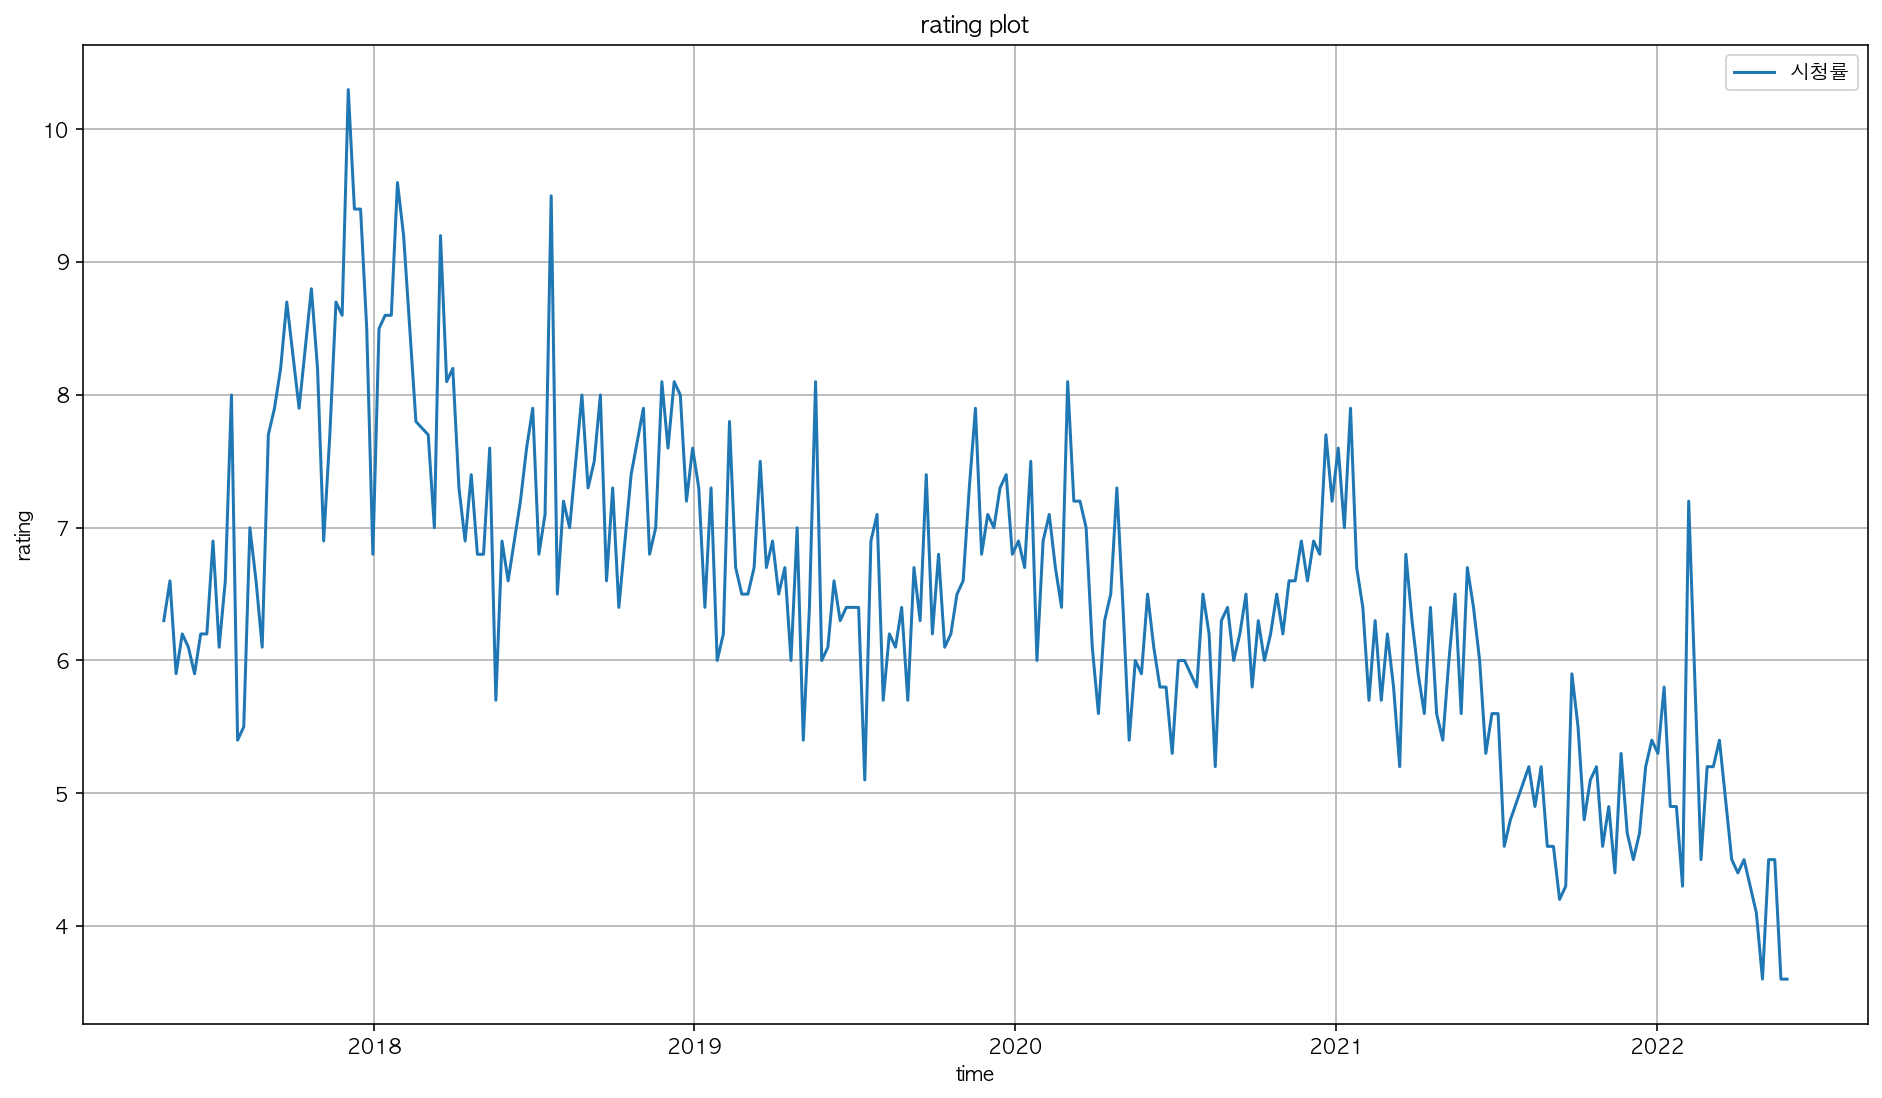

In [11]:
# 시청률 데이터 시각화
plt.figure(figsize=(16, 9))

plt.title("rating plot")
sns.lineplot(y=df['rating'], x=df.index, label = "시청률")
plt.xlabel('time')
plt.ylabel('rating')
plt.grid()
plt.show()

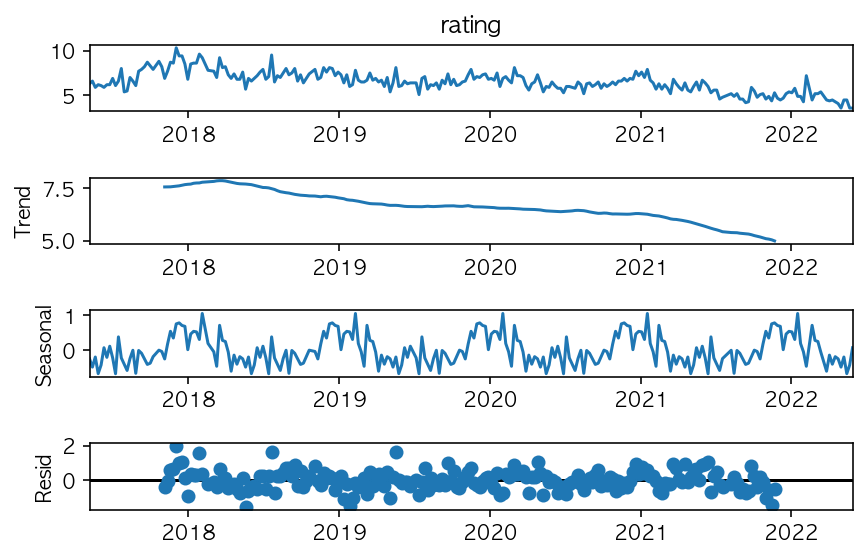

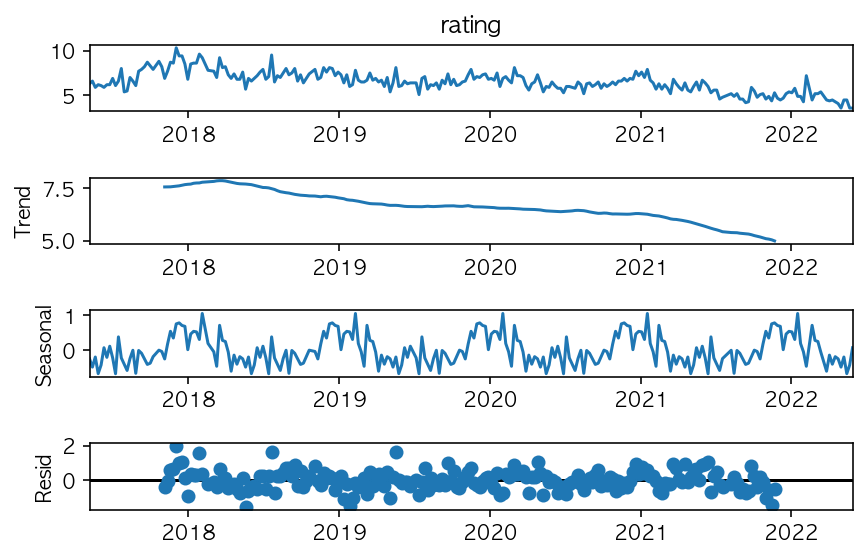

In [12]:
# 시청률 요인 분해 (시계열 데이터 요인 분해)
from statsmodels.tsa.seasonal import seasonal_decompose
model_series = seasonal_decompose(df['rating'], model = 'addictive', period = 50) # freq 설정 -> 주 수
# freq; 계절 주기당 기간 수 지정하는 정수 값. 주간 데이터 사용하므로 12달의 총 주수 사용
model_series.plot()

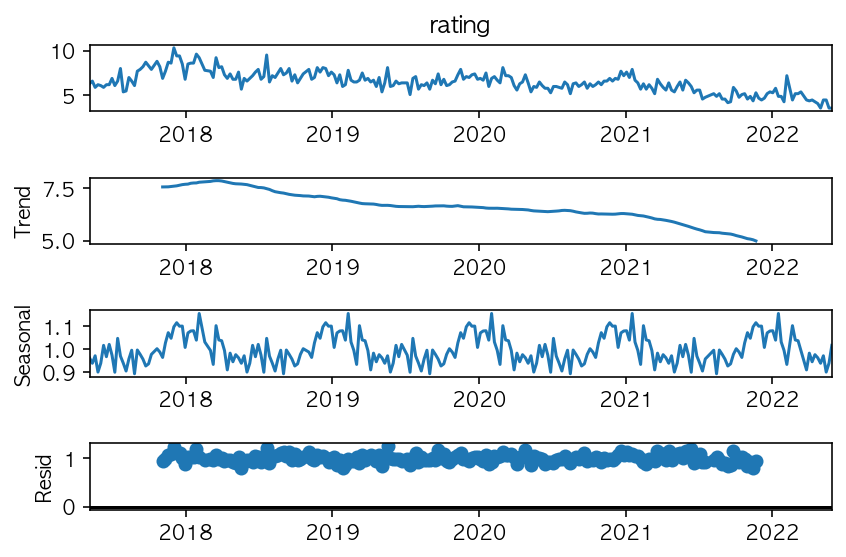

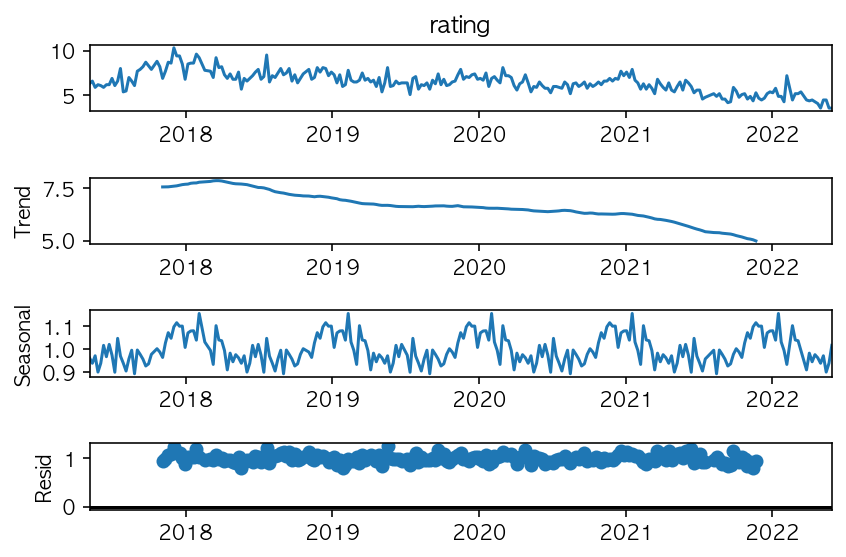

In [13]:
# 시청률 요인 분해 (시계열 데이터 요인 분해)
from statsmodels.tsa.seasonal import seasonal_decompose
model_series = seasonal_decompose(df['rating'], model = 'multiplicative', period = 50) # freq 설정 -> 주 수
# freq; 계절 주기당 기간 수 지정하는 정수 값. 주간 데이터 사용하므로 12달의 총 주수 사용
model_series.plot()

### 범주형 데이터 시각화 (=> 추가 그래프 고려)

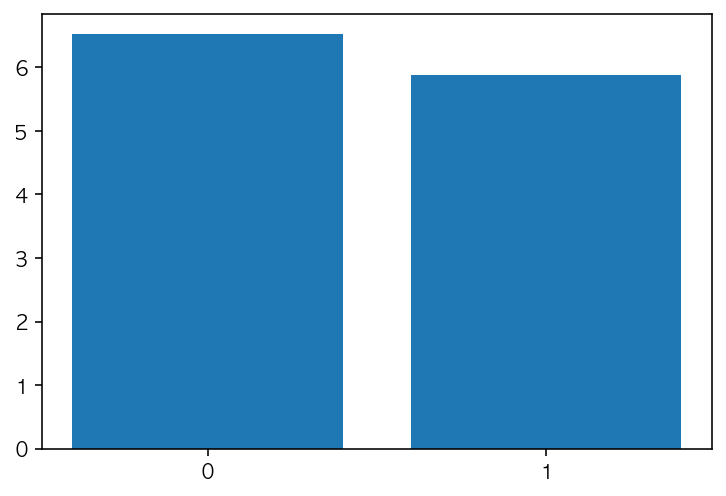

In [14]:
# holiday에 따른 시청률 시각화
holiday_rating = df.groupby('holiday').mean()['rating']
plt.bar(['0', '1'], holiday_rating.values) # 0이 공휴일 아님, 1이 공휴일
plt.show()


=> 공휴일일 때 시청률 평균이 조금 더 낮다<br>
=> 공휴일일 때 사람들의 외출으로 인해 시청률이 더 낮다

In [15]:
# 계절에 따른 평균 시청률 시각화
def func_season(x): # 3~5월은 봄, 6~8월은 여름, 9~11월은 가을, 1~2월은 겨울로 설정
    if x==3 or x==4 or x==5:
        return "spring"
    elif x==6 or x==7 or x==8:
        return "summer"
    elif x==9 or x==10 or x==11:
        return "fall"
    elif x==12 or x==1 or x==2:
        return "winter"

df['season']=df['month'].apply(lambda x : func_season(x))

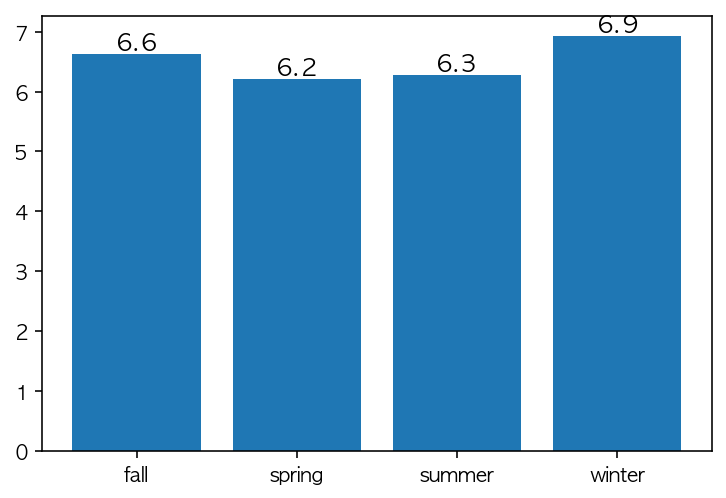

In [16]:
df['month']=df.index.month
season_rating=df.groupby(['season'])['rating'].mean()
bar=plt.bar(season_rating.index, season_rating.values)
# print('spring:',season_rating['spring'])
# print('summer:',season_rating['summer'])
# print('fall:',season_rating['fall'])
# print('winter:',season_rating['winter'])

# 바 위에 값 표시
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)

plt.show()

=> 시청률 평균은 봄에 가장 낮고, 겨울에 가장 높다<br>
=> 날씨가 좋은 봄에 외출이 많아 시청률이 낮다<br>
=> 겨울은 날씨가 추워 집에서 머무르는 시간이 많아 시청률이 높다

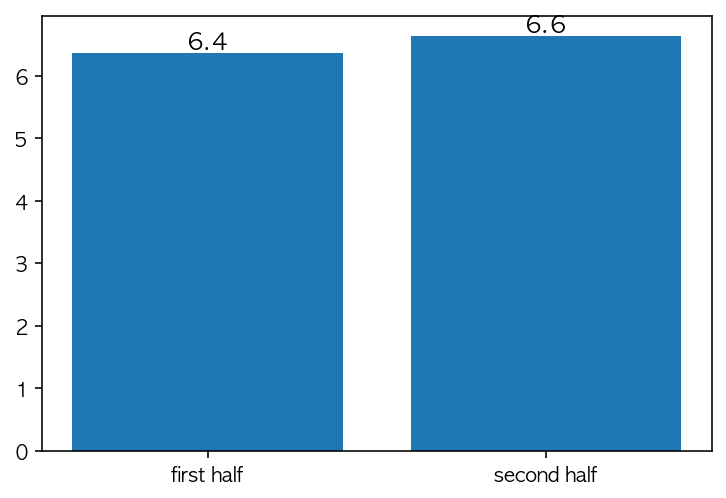

In [17]:
# 상/하반기에 따른 평균 시청률 시각화

def func_halfOfYear(x): # 1~6월은 상반기, 7~12월은 하반기
    if x>=1 and x<=6:
        return "first half"
    elif x>=7 and x<=12:
        return "second half"
    
df['half year']=df['month'].apply(lambda x: func_halfOfYear(x))

half_rating=df.groupby(['half year'])['rating'].mean()
bar=plt.bar(half_rating.index, half_rating.values)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)

plt.show()

=> 상반기 보다는 하반기에 평균 시청률이 높다<br>
-> 어떤 의미를 도출할 수 있을까?

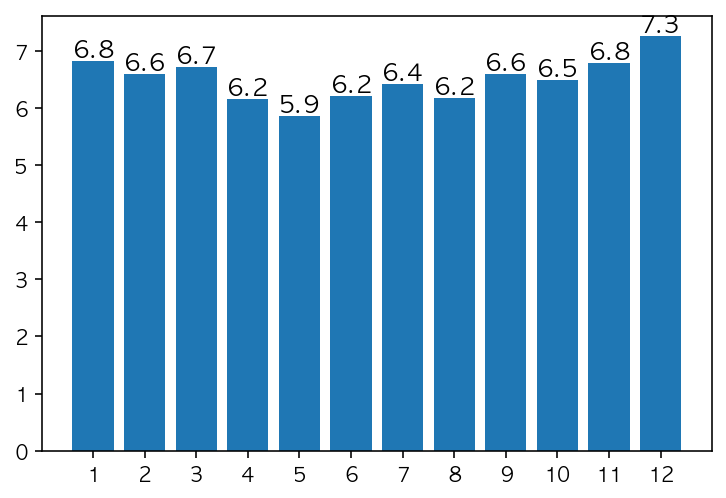

In [18]:
# 월별 평균 시청률 시각화

month_rating=df.groupby(['month'])['rating'].mean()
bar=plt.bar(['1','2','3','4','5','6','7','8','9','10','11','12'], month_rating.values)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)

plt.show()

=> 시청률이 5월에 가장 낮고, 12월에 가장 높다<br>
=> 5월은 가정의 달<br>
-> 어린이날, 어버이날, 스승의 날, 성년의 날, 부부의 날 등 가족과 관련된 기념일이 많아 외출에 증가로 인해 시청률이 낮다

<BarContainer object of 6 artists>

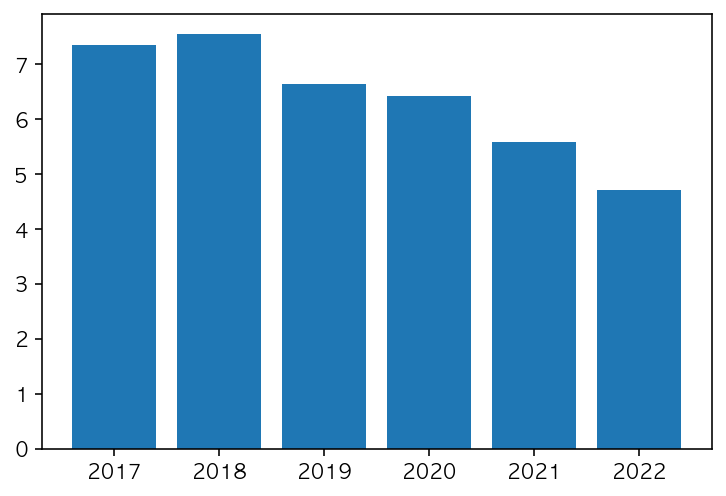

In [19]:
# year에 따른 시청률 시각화 (+ 여기에 상/하반기 추가해서 같이 봐도 괜찮을 듯 !)
year_rating = df.groupby('year').mean()['rating']
plt.bar(year_rating.index, year_rating.values)

=> 2017년 정철민 PD가 메인 PD가 된 후 런닝맨 황금기 맞이<br>
=> OTT 및 유튜브의 발달로 인해 TV로 본방송을 챙겨보는 사람수가 줄어 시청률 하락<br>
=> 런닝맨의 전체적인 시청률 흐름을 보여주면 년도마다 특징을 보여줄 수 있을 것 같은데 의미 있나 ?

<BarContainer object of 12 artists>

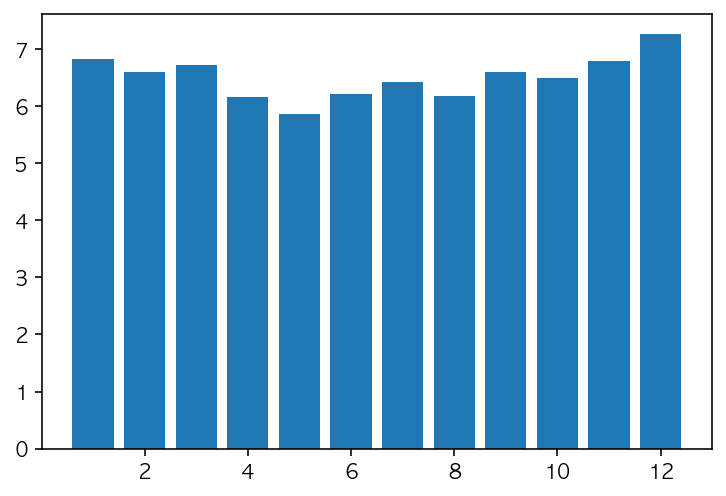

In [20]:
# month에 따른 시청률 시각화
month_rating = df.groupby('month').mean()['rating']
plt.bar(month_rating.index, month_rating.values)

### 데이터 관계 시각화 (=> 추가 그래프 고려)

<AxesSubplot:>

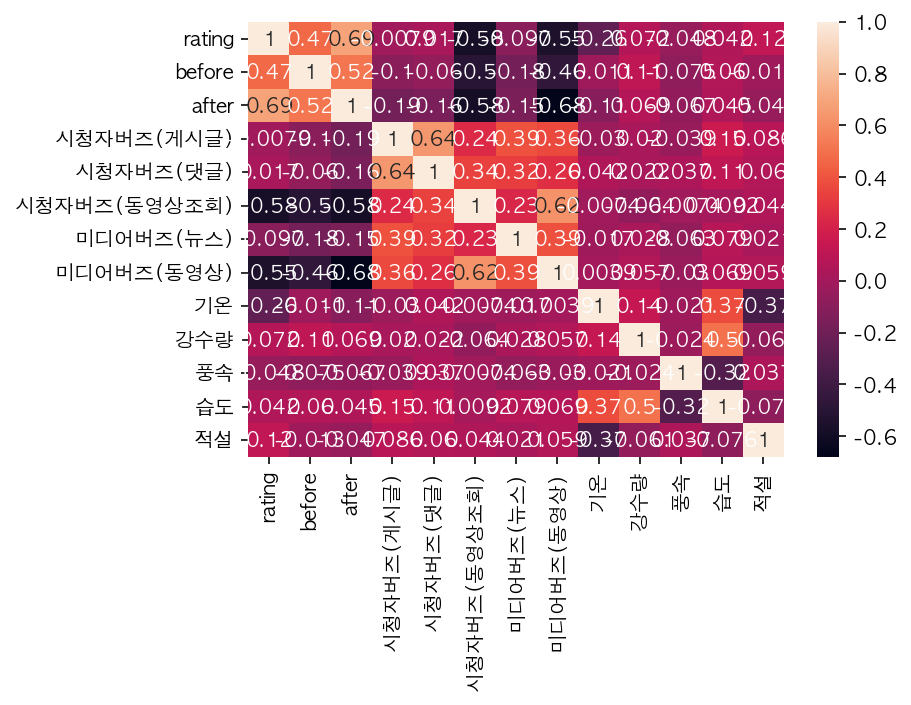

In [21]:
# 히트맵
df_corr = df.drop(['holiday', 'year', 'month'], axis = 1)
corr = df_corr.corr()
sns.heatmap(corr, annot = True)

=> 시청률과 상관관계를 나타내는 변수는 런닝맨 이후 시청률, 동영상과 관련된 시청자 버즈, 미디어 버즈<br>
=> 런닝맨 이후 시청률은 시청률과 양의 상관관계로, 런닝맨 이후 방송을 보기 위해 런닝맨을 시청하는 사람들이 있다고 판단<br>
=> 동영상 버즈는 시청률과 음의 상관관계로, 동영상 버즈가 긍정적인 영향보다는 멤버 및 프로그램의 사건, 사고와 관련된 부정적인 영향이 있다고 판단<br>
=> 버즈량을 나타내는 변수끼리 상관관계가 높아 다중공선성 문제 우려<br>
=> 버즈량끼리 크기 차이가 많이 나기 때문에 정규화 후 이를 평균 낸 통합변수 고려<br>

### 시각화 후 피처 엔지니어링

In [22]:
# 피처값 스케일링
scaler1 = MinMaxScaler()
scaled_feature_df = scaler1.fit_transform(df.drop(['rating', 'year', 'month','half year','season'], axis = 1))
scaled_feature_df = pd.DataFrame(scaled_feature_df, columns = ['holiday', 'after', '시청자버즈(게시글)', 
                                                               '시청자버즈(댓글)', '시청자버즈(동영상조회)', 
                                                               '미디어버즈(뉴스)', '미디어버즈(동영상)', 
                                                               '기온', '강수량', '풍속', '습도', '적설'])

# 라벨값 스케일링
scaler2 = MinMaxScaler()
scaled_label_df = scaler2.fit_transform(df['rating'].values.reshape(-1,1))
scaled_label_df = pd.DataFrame(scaled_label_df, columns = ['rating'])

ValueError: Shape of passed values is (256, 13), indices imply (256, 12)

In [ ]:
scaled_feature_df['통합 버즈'] = (scaled_feature_df['시청자버즈(게시글)'] + scaled_feature_df['시청자버즈(댓글)'] + scaled_feature_df['시청자버즈(동영상조회)'] + scaled_feature_df['미디어버즈(뉴스)'] + scaled_feature_df['미디어버즈(동영상)']) / 5
scaled_feature_df.drop(['시청자버즈(게시글)', '시청자버즈(댓글)', '시청자버즈(동영상조회)', '미디어버즈(뉴스)', '미디어버즈(동영상)'], axis = 1, inplace = True)
df_corr = pd.concat([scaled_label_df, scaled_feature_df], axis = 1)
corr = df_corr.corr()
sns.heatmap(corr, annot = True)


=> 버즈량 변수에서의 다중공선성 문제 해결 완료<br>
(다중공선성: 회귀분석에서 독립변수들 간에 강한 상관관계가 나타나는 문제)

### 후진제거법
https://wotres.tistory.com/entry/%ED%9B%84%EC%A7%84-%EC%A0%9C%EA%B1%B0%EB%B2%95-Backward-Elimination-in-python

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.datasets import make_regression

X=df.drop(['rating', 'year', 'month'], axis = 1)
X['통합 버즈'] = (X['시청자버즈(게시글)'] + X['시청자버즈(댓글)'] + X['시청자버즈(동영상조회)'] + X['미디어버즈(뉴스)'] + X['미디어버즈(동영상)']) / 5
X.drop(['시청자버즈(게시글)', '시청자버즈(댓글)', '시청자버즈(동영상조회)', '미디어버즈(뉴스)', '미디어버즈(동영상)'], axis = 1, inplace = True)

y=df['rating'].values.reshape(-1,1)

# n_samples: 표본 데이터 수, n_features: 독립변수 수, n_informative=독립변수중 종속변수와 상관관계 있는 성분 수 
X,y=make_regression(n_samples=256, n_features=9, n_informative=3, random_state=1)

from sklearn.linear_model import LinearRegression
lr=LinearRegression()

# 모델 입력, n_features_to_select: 골라낼 변수의 수, step: 한번에 몇개씩 제거할 건지
rfe=RFE(lr, n_features_to_select=5, step=1)
model=rfe.fit(X,y)

In [ ]:
# 선택될 변수
model.support_

In [ ]:
# 변수 중요도 (높을수록 불필요)
model.ranking_


# ✨ 여기 아래부터 다시 보기

# 2. 모델링 및 성능평가 / 개선

In [ ]:
df = pd.concat([scaled_label_df, scaled_feature_df], axis = 1)

In [ ]:
window_size = 20
TEST_SIZE = int(len(df) * 0.7)

In [ ]:
train = df[:TEST_SIZE]
test = df[TEST_SIZE:]

## 200일의 데이터를 얼마나 잘 예측하느냐

In [ ]:
train

In [ ]:
test

In [ ]:
# 데이터셋을 만들어 주는 함수

def make_dataset(feature, label, window_size = 1):
  
  feature_list = []
  label_list = []
  
  for i in range(len(feature) - window_size) :
    feature_list.append(feature.iloc[i:i+window_size])
    label_list.append(label.iloc[i+window_size])
  
  return np.array(feature_list), np.array(label_list)

# ✨

* target 값인 시청률을 피처에도 넣어 고려를 해보는 게 좋을지 ..? => x

In [ ]:
feature_cols = scaled_feature_df.columns
label_cols = ['rating']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 25)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, shuffle = False)
x_train.shape, x_valid.shape

In [ ]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature , test_label = make_dataset(test_feature, test_label,25)

* output은 하나로 나와야함 !!!<br>
* multi layer lstm example 구글링

In [ ]:
model = Sequential()

model.add(LSTM(16,
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu')
          )
model.add(Dense(1))
model.add(Dropout(0.2))

#LSTM의 첫번재 옵션 unit은 output의 차원
#time_steps(window_size)이 train_features.shape[1], features이 train_features.shape[2] 
#예측하고자하는 target의 갯수가 1이므로 마지막에 Dense(1)을 하나 추가

In [ ]:
model.summary()

In [ ]:
train_feature.shape[1], train_feature.shape[2]

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
#실제 연속적인 값을 예측하는 것이기 때문에 loss function은 mse
#일반적으로 optimizer은 adam 주로 사용
early_stop = EarlyStopping(monitor='val_loss', patience=10)
#10회 Epoch동안 개선되지 않는다면 종료

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=25,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

In [ ]:
model.load_weights(filename)

pred = model.predict(test_feature)

plt.figure(figsize = (16,9))
plt.xlabel("time")
plt.ylabel("price")
plt.plot(test_label, label="actual")
plt.plot(pred, label="prediction")
plt.grid()
plt.legend(loc="best")
plt.show()

In [ ]:
rescaled_y_true = scaler2.inverse_transform(np.array(test_label).reshape(-1, 1))
rescaled_pred = scaler2.inverse_transform(np.array(pred).reshape(-1,1))

In [ ]:
plt.figure(figsize = (16,9))
plt.xlabel("time")
plt.ylabel("price")
plt.plot(rescaled_y_true, label="actual")
plt.plot(rescaled_pred, label="prediction")
plt.grid()
plt.legend(loc="best")
plt.show()

In [ ]:
# 평가지표 함수

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
        
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                            index = ['MAE','RMSE', 'RMSLE', 'R2'],
                            columns=['Results'])
    return Result

In [ ]:
confirm_result(rescaled_y_true, rescaled_pred)